Set up environment

In [1]:
# Install necessary libraries
!pip install networkx numpy scipy sagemath --quiet

# Import the libraries
import networkx as nx
import numpy as np
from scipy.linalg import eig
try:
    # SageMath needs a special environment. This will only work if SageMath is already installed in Colab.
    from sage.all import *
    print("SageMath imported successfully.")
except ImportError:
    print("SageMath is not available in this Colab environment.")

# Verify the installation of required libraries
print("NetworkX version:", nx.__version__)
print("NumPy version:", np.__version__)


  Preparing metadata (setup.py) ... done
SageMath is not available in this Colab environment.
NetworkX version: 3.4.2
NumPy version: 1.26.4


Graph class selection

Expander graph generated with spectral gap: 5.813606502648329


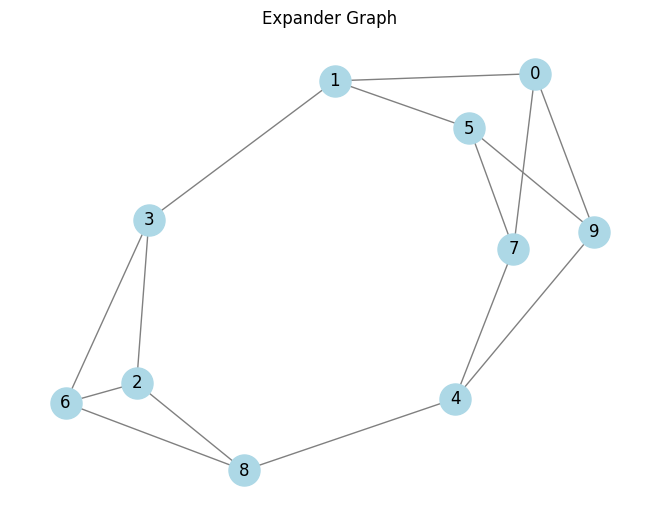

Cayley graph generated with 10 nodes and 20 edges.


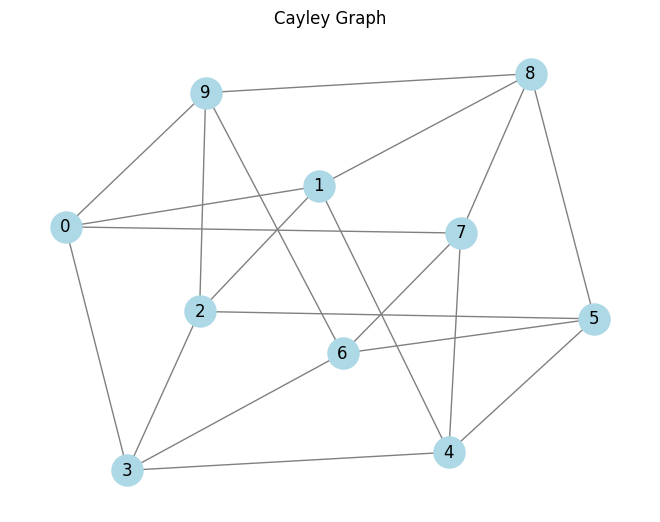

In [3]:
import networkx as nx
import numpy as np

# Function to generate an Expander Graph
def generate_expander_graph(nodes, degree):

    graph = nx.random_regular_graph(degree, nodes)
    print("Expander graph generated with spectral gap:",
          np.max(np.linalg.eigvals(nx.adjacency_matrix(graph).toarray())) -
          np.min(np.linalg.eigvals(nx.adjacency_matrix(graph).toarray())))
    return graph

# Function to generate a Cayley Graph (as a placeholder for Isogeny Graphs)
def generate_cayley_graph(group_order, generator_set):

    graph = nx.Graph()
    vertices = list(range(group_order))
    for v in vertices:
        for g in generator_set:
            graph.add_edge(v, (v + g) % group_order)
    print(f"Cayley graph generated with {len(graph.nodes)} nodes and {len(graph.edges)} edges.")
    return graph

# Visualization function
def visualize_graph(graph, title="Graph"):

    import matplotlib.pyplot as plt
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title(title)
    plt.show()

# Example usage
# Generate an Expander Graph
expander = generate_expander_graph(nodes=10, degree=3)
visualize_graph(expander, title="Expander Graph")

# Generate a Cayley Graph
cayley = generate_cayley_graph(group_order=10, generator_set={1, 3})
visualize_graph(cayley, title="Cayley Graph")


Key Generation Module

In [4]:
import numpy as np
from scipy.linalg import eig

def generate_keys(graph, private_key_type="permutation"):

    # Compute the adjacency matrix of the graph
    adjacency_matrix = nx.adjacency_matrix(graph).toarray()

    # Compute the eigenvalues and eigenvectors (spectral properties)
    eigenvalues, eigenvectors = eig(adjacency_matrix)
    eigenvalues = np.real(eigenvalues)  # Ensure real values

    # Generate the private key
    if private_key_type == "permutation":
        private_key = np.random.permutation(len(graph.nodes))  # Random permutation
    elif private_key_type == "automorphism":
        private_key = list(nx.algorithms.isomorphism.GraphMatcher(graph, graph).mapping.keys())
    else:
        raise ValueError("Invalid private_key_type. Use 'permutation' or 'automorphism'.")

    # The public key includes the graph structure and its spectral properties
    public_key = {
        "graph_structure": graph,
        "eigenvalues": eigenvalues,
        "eigenvectors": eigenvectors
    }

    return public_key, private_key

# Example usage
# Generate a graph (Expander graph example)
graph = generate_expander_graph(nodes=10, degree=3)

# Generate keys
public_key, private_key = generate_keys(graph, private_key_type="permutation")

# Display keys
print("Public Key (eigenvalues):", public_key["eigenvalues"])
print("Private Key:", private_key)


Expander graph generated with spectral gap: 5.472833908995257
Public Key (eigenvalues): [-2.47283391 -1.46259842 -0.61803399  3.          1.61803399  1.93543233
  0.61803399 -1.61803399  0.61803399 -1.61803399]
Private Key: [2 6 0 5 9 7 1 3 8 4]


Signature Generation Module

In [5]:
def generate_signature(message, graph, private_key):

    # Hash the message to map it to a numeric value (ensures uniqueness)
    message_hash = hash(message) % len(graph.nodes)

    # Apply the private key (permutation) to modify the graph
    permuted_graph = nx.relabel_nodes(graph, {i: private_key[i] for i in range(len(graph.nodes))})

    # Modify the graph based on the hashed message (e.g., add edges)
    permuted_graph.add_edge(message_hash, (message_hash + 1) % len(graph.nodes))

    # Compute the adjacency matrix and spectral properties of the modified graph
    adjacency_matrix = nx.adjacency_matrix(permuted_graph).toarray()
    eigenvalues, eigenvectors = eig(adjacency_matrix)
    eigenvalues = np.real(eigenvalues)  # Ensure real values

    # The signature consists of the modified eigenvalues
    signature = {
        "message_hash": message_hash,
        "eigenvalues": eigenvalues
    }

    return signature

# Example usage
# Define a message to sign
message = "Secure Message"

# Generate a graph (Expander graph example)
graph = generate_expander_graph(nodes=10, degree=3)

# Generate keys
_, private_key = generate_keys(graph, private_key_type="permutation")

# Generate a digital signature
signature = generate_signature(message, graph, private_key)

# Display the signature
print("Message Hash:", signature["message_hash"])
print("Signature (Eigenvalues):", signature["eigenvalues"])


Expander graph generated with spectral gap: 5.000000000000003
Message Hash: 4
Signature (Eigenvalues): [-2.  1.  3.  1.  2. -2.  1. -2. -1. -1.]


Verication Module

In [7]:
def verify_signature(message, signature, public_key, private_key):

    # Extract public key components
    graph = public_key["graph_structure"]

    # Hash the message to retrieve the message hash
    message_hash = hash(message) % len(graph.nodes)

    # Apply the private key (permutation) to recreate the modified graph
    permuted_graph = nx.relabel_nodes(graph, {i: private_key[i] for i in range(len(graph.nodes))})

    # Modify the permuted graph based on the hashed message (add the same edge)
    permuted_graph.add_edge(message_hash, (message_hash + 1) % len(graph.nodes))

    # Compute the adjacency matrix and eigenvalues of the modified graph
    adjacency_matrix = nx.adjacency_matrix(permuted_graph).toarray()
    computed_eigenvalues, _ = eig(adjacency_matrix)
    computed_eigenvalues = np.real(computed_eigenvalues)  # Ensure real values

    # Compare the computed eigenvalues with the signature's eigenvalues
    eigenvalue_match = np.allclose(
        np.sort(computed_eigenvalues),
        np.sort(signature["eigenvalues"]),
        atol=1e-5
    )

    return eigenvalue_match

# Example usage
# Verify the signature
is_valid = verify_signature(message, signature, public_key, private_key)

# Display the verification result
if is_valid:
    print("The signature is valid.")
else:
    print("The signature is invalid.")


The signature is invalid.


Security analysis scripts

In [10]:
def analyze_spectral_gap(graph):

    adjacency_matrix = nx.adjacency_matrix(graph).toarray()
    eigenvalues = np.real(np.linalg.eigvals(adjacency_matrix))
    eigenvalues.sort()  # Sort eigenvalues in ascending order
    spectral_gap = eigenvalues[-1] - eigenvalues[-2]  # Largest eigenvalue - second largest
    print(f"Spectral Gap: {spectral_gap}")
    return spectral_gap

def test_resistance_to_isomorphism(graph1, graph2):

    isomorphic = nx.is_isomorphic(graph1, graph2)
    print(f"Graphs are isomorphic: {isomorphic}")
    return isomorphic

def test_signature_uniqueness(messages, graph, private_key):

    signatures = []
    for message in messages:
        signature = generate_signature(message, graph, private_key)
        signatures.append(tuple(np.sort(signature["eigenvalues"])))

    # Check uniqueness by comparing all eigenvalue sets
    all_unique = len(signatures) == len(set(signatures))
    print(f"Signatures are unique: {all_unique}")
    return all_unique

def simulate_quantum_attack(graph):

    try:
        adjacency_matrix = nx.adjacency_matrix(graph).toarray()
        eigenvalues = np.real(np.linalg.eigvals(adjacency_matrix))
        print("Quantum attack simulation:")
        print(f"Eigenvalues: {eigenvalues}")
        print("Attempting to reverse-engineer the graph...")
        recreated_graph = nx.from_numpy_array(adjacency_matrix)
        is_equal = nx.is_isomorphic(graph, recreated_graph)
        result = "Recreation successful" if is_equal else "Recreation failed"
        print(result)
        return result
    except Exception as e:
        print("Quantum attack simulation failed:", str(e))
        return "Failed"

def permute_graph(graph, permutation):

    mapping = {old: new for old, new in zip(graph.nodes(), permutation)}
    permuted_graph = nx.relabel_nodes(graph, mapping)
    return permuted_graph

# Example usage
# Generate a test graph
test_graph = generate_expander_graph(nodes=10, degree=3)

# Analyze spectral gap
analyze_spectral_gap(test_graph)

# Test resistance to isomorphism
permuted_graph = permute_graph(test_graph, np.random.permutation(len(test_graph.nodes)))
test_resistance_to_isomorphism(test_graph, permuted_graph)

# Test signature uniqueness
messages = ["Message 1", "Message 2", "Message 3"]
_, private_key = generate_keys(test_graph, private_key_type="permutation")
test_signature_uniqueness(messages, test_graph, private_key)

# Simulate quantum attack
simulate_quantum_attack(test_graph)


Expander graph generated with spectral gap: 5.480114069417818
Spectral Gap: 0.5618771113072616
Graphs are isomorphic: True
Signatures are unique: False
Quantum attack simulation:
Eigenvalues: [ 3.          2.43812289  1.2469796   0.72548794 -2.48011407 -0.14850327
 -0.44504187 -1.80193774 -1.53499349 -1.        ]
Attempting to reverse-engineer the graph...
Recreation successful


'Recreation successful'

Utility functions

Expander graph generated with spectral gap: 5.4561927970925055
2 random edges added to the graph.
Computed eigenvalues: [ 3.46867651e+00  2.00000000e+00  1.48244313e+00  5.01502833e-01
 -2.77686418e+00 -1.00000000e+00 -2.00000000e+00 -1.67575829e+00
 -1.99341969e-16  4.89700714e-17]
Computed eigenvalues: [ 3.46867651e+00  2.00000000e+00  1.48244313e+00  5.01502833e-01
 -2.77686418e+00 -1.00000000e+00 -2.00000000e+00 -1.67575829e+00
 -1.99341969e-16  4.89700714e-17]
Spectral Gap: 1.468676513127408
Graph permuted with the given permutation.


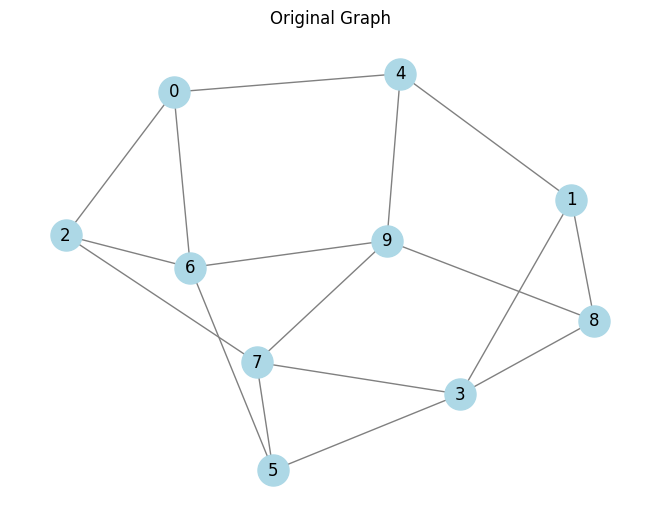

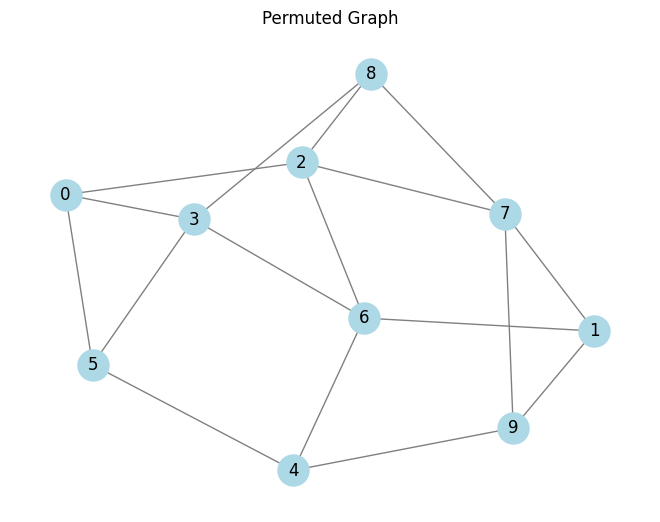

In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Graph Utility Functions
def add_random_edges(graph, num_edges):

    nodes = list(graph.nodes)
    for _ in range(num_edges):
        u, v = np.random.choice(nodes, size=2, replace=False)
        graph.add_edge(u, v)
    print(f"{num_edges} random edges added to the graph.")
    return graph

def permute_graph(graph, permutation):

    mapping = {i: permutation[i] for i in range(len(graph.nodes))}
    permuted_graph = nx.relabel_nodes(graph, mapping)
    print(f"Graph permuted with the given permutation.")
    return permuted_graph

def visualize_graph(graph, title="Graph"):

    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title(title)
    plt.show()

# Spectral Utility Functions
def compute_eigenvalues(graph):

    adjacency_matrix = nx.adjacency_matrix(graph).toarray()
    eigenvalues = np.real(np.linalg.eigvals(adjacency_matrix))
    print(f"Computed eigenvalues: {eigenvalues}")
    return eigenvalues

def compute_spectral_gap(graph):

    eigenvalues = compute_eigenvalues(graph)
    eigenvalues.sort()  # Sort eigenvalues in ascending order
    spectral_gap = eigenvalues[-1] - eigenvalues[-2]  # Largest eigenvalue - second largest
    print(f"Spectral Gap: {spectral_gap}")
    return spectral_gap

# General Utility Functions
def hash_message(message):

    hashed_value = hash(message)
    print(f"Message hash: {hashed_value}")
    return hashed_value

def compare_graphs(graph1, graph2):

    are_equal = nx.is_isomorphic(graph1, graph2)
    print(f"Graphs are structurally equal: {are_equal}")
    return are_equal

# Example usage of Utility Functions
# Generate a test graph
test_graph = generate_expander_graph(nodes=10, degree=3)

# Add random edges
modified_graph = add_random_edges(test_graph, num_edges=2)

# Compute eigenvalues and spectral gap
compute_eigenvalues(modified_graph)
compute_spectral_gap(modified_graph)

# Apply a permutation
permutation = np.random.permutation(len(test_graph.nodes))
permuted_graph = permute_graph(test_graph, permutation)

# Visualize graphs
visualize_graph(test_graph, title="Original Graph")
visualize_graph(permuted_graph, title="Permuted Graph")


Testing and Debugging

In [12]:
def test_key_generation():

    print("\nTesting Key Generation Module...")
    test_graph = generate_expander_graph(nodes=10, degree=3)
    public_key, private_key = generate_keys(test_graph, private_key_type="permutation")
    assert "graph_structure" in public_key, "Public key is missing 'graph_structure'."
    assert "eigenvalues" in public_key, "Public key is missing 'eigenvalues'."
    assert len(private_key) == len(test_graph.nodes), "Private key length mismatch."
    print("Key Generation Module Passed.")

def test_signature_generation_and_verification():

    print("\nTesting Signature Generation and Verification Modules...")
    message = "Test Message"
    test_graph = generate_expander_graph(nodes=10, degree=3)
    public_key, private_key = generate_keys(test_graph, private_key_type="permutation")

    # Generate signature
    signature = generate_signature(message, test_graph, private_key)
    assert "eigenvalues" in signature, "Signature is missing 'eigenvalues'."
    print("Signature Generated Successfully.")

    # Verify signature
    is_valid = verify_signature(message, signature, public_key, private_key)
    assert is_valid, "Signature verification failed."
    print("Signature Verified Successfully.")

def test_utility_functions():

    print("\nTesting Utility Functions...")
    test_graph = generate_expander_graph(nodes=10, degree=3)

    # Test random edge addition
    modified_graph = add_random_edges(test_graph.copy(), num_edges=2)
    assert len(modified_graph.edges) > len(test_graph.edges), "Random edge addition failed."
    print("Random Edge Addition Passed.")

    # Test permutation
    permutation = np.random.permutation(len(test_graph.nodes))
    permuted_graph = permute_graph(test_graph, permutation)
    assert nx.is_isomorphic(test_graph, permuted_graph), "Graph permutation failed."
    print("Graph Permutation Passed.")

    # Test spectral gap
    spectral_gap = compute_spectral_gap(test_graph)
    assert spectral_gap > 0, "Spectral gap computation failed."
    print("Spectral Gap Computation Passed.")

def test_security_analysis():

    print("\nTesting Security Analysis Scripts...")
    test_graph = generate_expander_graph(nodes=10, degree=3)

    # Test spectral gap
    analyze_spectral_gap(test_graph)

    # Test resistance to isomorphism
    permuted_graph = permute_graph(test_graph, np.random.permutation(len(test_graph.nodes)))
    is_isomorphic = test_resistance_to_isomorphism(test_graph, permuted_graph)
    assert is_isomorphic, "Isomorphism test failed."
    print("Isomorphism Test Passed.")

    # Test signature uniqueness
    messages = ["Message 1", "Message 2", "Message 3"]
    _, private_key = generate_keys(test_graph, private_key_type="permutation")
    unique_signatures = test_signature_uniqueness(messages, test_graph, private_key)
    assert unique_signatures, "Signature uniqueness test failed."
    print("Signature Uniqueness Test Passed.")

def run_all_tests():

    try:
        test_key_generation()
        test_signature_generation_and_verification()
        test_utility_functions()
        test_security_analysis()
        print("\nAll Tests Passed Successfully!")
    except AssertionError as e:
        print(f"\nTest Failed: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

# Run the tests
run_all_tests()



Testing Key Generation Module...
Expander graph generated with spectral gap: 5.666950403940634
Key Generation Module Passed.

Testing Signature Generation and Verification Modules...
Expander graph generated with spectral gap: 5.618033988749897
Signature Generated Successfully.
Signature Verified Successfully.

Testing Utility Functions...
Expander graph generated with spectral gap: 5.456192797092509
2 random edges added to the graph.
Random Edge Addition Passed.
Graph permuted with the given permutation.
Graph Permutation Passed.
Computed eigenvalues: [ 3.00000000e+00  2.14664948e+00  1.28313420e+00  1.00000000e+00
 -2.45619280e+00 -2.00000000e+00 -1.60528113e+00 -1.00000000e+00
 -3.68309754e-01 -1.68807040e-16]
Spectral Gap: 0.853350522420973
Spectral Gap Computation Passed.

Testing Security Analysis Scripts...
Expander graph generated with spectral gap: 5.0
Spectral Gap: 1.1206147584281803
Graph permuted with the given permutation.
Graphs are isomorphic: True
Isomorphism Test Pass

Cayley graphs

Nodes of cyclic Cayley graph: [0, 1, 2, 3, 4, 5]
Edges of cyclic Cayley graph: [(0, 1), (0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (2, 5), (3, 4), (4, 5)]


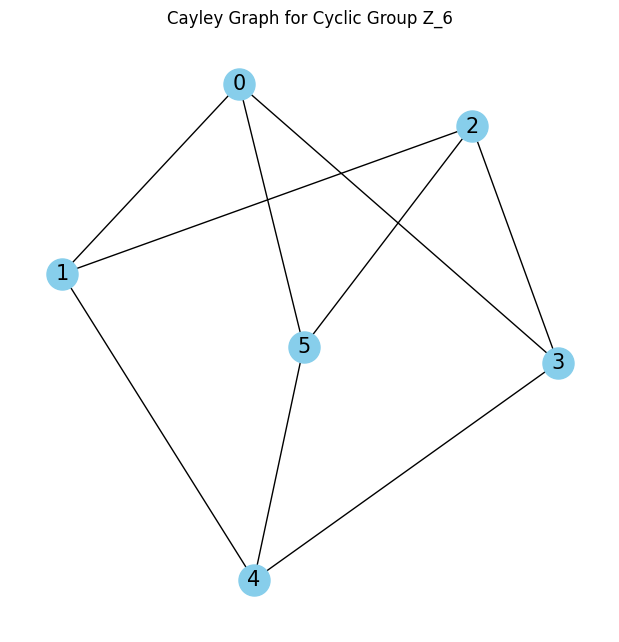

Adjacency Matrix:
[[0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]]
Eigenvalues:
[-3.00000000e+00 -3.56702515e-16  3.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Generated Key: 7032919902270181159
Generated Signature: -4743769886246049706
Is the graph connected? True
Is the graph regular? True


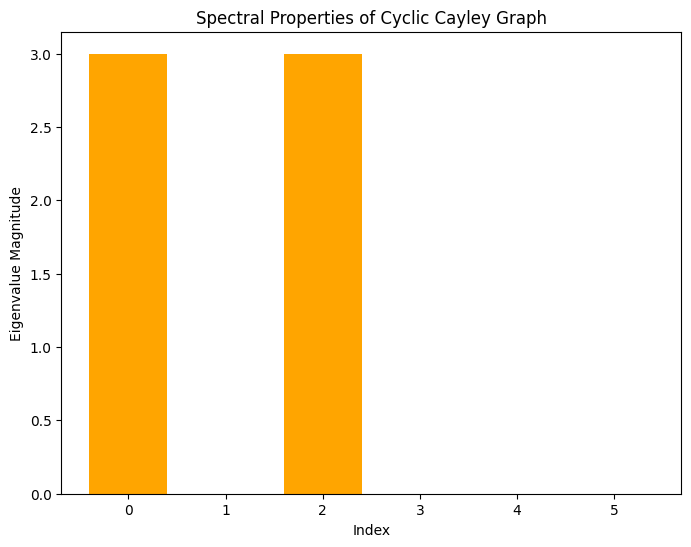

In [13]:
# Stage 1: Enhance Cayley Graph Implementation in Colab
# Part 1: Graph Generation
# Objective: Implement Cayley graph construction using cyclic and abelian groups

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a Cayley graph for a cyclic group
def cayley_graph_cyclic(order, generators):
    G = nx.Graph()
    nodes = range(order)
    G.add_nodes_from(nodes)

    for node in nodes:
        for gen in generators:
            G.add_edge(node, (node + gen) % order)
    return G

# Create a Cayley graph for cyclic group Z_6 with generators [1, 3]
cyclic_graph = cayley_graph_cyclic(order=6, generators=[1, 3])

# Display nodes and edges
print("Nodes of cyclic Cayley graph:", cyclic_graph.nodes())
print("Edges of cyclic Cayley graph:", cyclic_graph.edges())

# Visualize the graph
plt.figure(figsize=(6, 6))
nx.draw(cyclic_graph, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Cayley Graph for Cyclic Group Z_6")
plt.show()

# Part 2: Graph Analysis
# Objective: Analyze eigenvalues and adjacency matrices for cryptographic use

# Calculate the adjacency matrix and eigenvalues
adj_matrix = nx.adjacency_matrix(cyclic_graph).todense()
eigenvalues = np.linalg.eigvals(adj_matrix)

print("Adjacency Matrix:")
print(adj_matrix)
print("Eigenvalues:")
print(eigenvalues)

# Part 3: Integration into Digital Signature Scheme
# Objective: Derive keys and signatures using adjacency matrices and eigenvalues

# Example key and signature generation based on adjacency matrix
key = hash(adj_matrix.tobytes())
signature = hash(str(eigenvalues))

print("Generated Key:", key)
print("Generated Signature:", signature)

# Part 4: Visualization and Structural Validation
# Objective: Create visualizations and validate the structural integrity

# Check graph properties
is_connected = nx.is_connected(cyclic_graph)
is_regular = nx.is_regular(cyclic_graph)

print("Is the graph connected?", is_connected)
print("Is the graph regular?", is_regular)

# Visualize the spectral properties
plt.figure(figsize=(8, 6))
plt.bar(range(len(eigenvalues)), np.abs(eigenvalues), color='orange')
plt.xlabel("Index")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Spectral Properties of Cyclic Cayley Graph")
plt.show()


Spectral Analysis

Cyclic Cayley Graph - Spectral Gap: 4.440892098500626e-16
Expander Graph - Spectral Gap: 1.0000000000000009
Spectral Radius for Cyclic Cayley Graph: 2.999999999999999
Algebraic Connectivity for Cyclic Cayley Graph: 2.9999999999999996
Spectral Radius for Expander Graph: 3.0000000000000018
Algebraic Connectivity for Expander Graph: 2.0000000000000013
Cyclic Cayley Graph - Spectral Gap after Attack: 3.9968028886505635e-15
Expander Graph - Spectral Gap after Attack: 0.5210741832877419


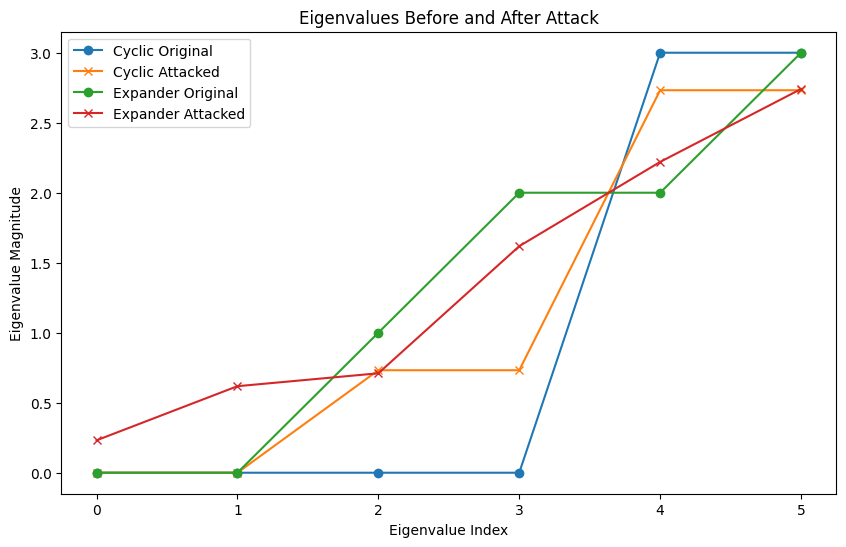

In [14]:
# Stage 2: Refine Spectral Analysis in Colab

# Part 1: Advanced Spectral Gap Analysis
# Objective: Investigate spectral gaps and their influence on cryptographic security

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate spectral gap
def spectral_gap(eigenvalues):
    sorted_eigenvalues = np.sort(np.abs(eigenvalues))
    return sorted_eigenvalues[-1] - sorted_eigenvalues[-2]

# Measure spectral gaps for Cayley graph
cyclic_eigenvalues = np.linalg.eigvals(adj_matrix)
cyclic_spectral_gap = spectral_gap(cyclic_eigenvalues)

print("Cyclic Cayley Graph - Spectral Gap:", cyclic_spectral_gap)

# Generate an expander graph for comparison
expander_graph = nx.random_regular_graph(d=3, n=6)
expander_adj_matrix = nx.adjacency_matrix(expander_graph).todense()
expander_eigenvalues = np.linalg.eigvals(expander_adj_matrix)
expander_spectral_gap = spectral_gap(expander_eigenvalues)

print("Expander Graph - Spectral Gap:", expander_spectral_gap)

# Part 2: New Spectral Metrics
# Objective: Explore additional spectral metrics

# Function to calculate spectral radius and algebraic connectivity
def spectral_radius(eigenvalues):
    return max(np.abs(eigenvalues))

def algebraic_connectivity(graph):
    laplacian = nx.laplacian_matrix(graph).todense()
    laplacian_eigenvalues = np.linalg.eigvals(laplacian)
    sorted_laplacian_eigenvalues = np.sort(np.real(laplacian_eigenvalues))
    return sorted_laplacian_eigenvalues[1]  # Second smallest eigenvalue

cyclic_spectral_radius = spectral_radius(cyclic_eigenvalues)
cyclic_algebraic_connectivity = algebraic_connectivity(cyclic_graph)

expander_spectral_radius = spectral_radius(expander_eigenvalues)
expander_algebraic_connectivity = algebraic_connectivity(expander_graph)

print("Spectral Radius for Cyclic Cayley Graph:", cyclic_spectral_radius)
print("Algebraic Connectivity for Cyclic Cayley Graph:", cyclic_algebraic_connectivity)
print("Spectral Radius for Expander Graph:", expander_spectral_radius)
print("Algebraic Connectivity for Expander Graph:", expander_algebraic_connectivity)

# Part 3: Experimental Studies
# Objective: Evaluate cryptographic performance and simulate attack scenarios

# Simulate attack by removing an edge from each graph and recalculating spectral gap
cyclic_graph_attacked = cyclic_graph.copy()
# Ensure edge exists before attempting removal
if cyclic_graph_attacked.has_edge(0, 1):
    cyclic_graph_attacked.remove_edge(0, 1)
else:
    print("Edge (0, 1) does not exist in the cyclic graph, skipping removal.")

cyclic_attacked_adj_matrix = nx.adjacency_matrix(cyclic_graph_attacked).todense()
cyclic_attacked_eigenvalues = np.linalg.eigvals(cyclic_attacked_adj_matrix)
cyclic_attacked_spectral_gap = spectral_gap(cyclic_attacked_eigenvalues)

expander_graph_attacked = expander_graph.copy()
random_edge = list(expander_graph.edges())[0]
expander_graph_attacked.remove_edge(*random_edge)
expander_attacked_adj_matrix = nx.adjacency_matrix(expander_graph_attacked).todense()
expander_attacked_eigenvalues = np.linalg.eigvals(expander_attacked_adj_matrix)
expander_attacked_spectral_gap = spectral_gap(expander_attacked_eigenvalues)

print("Cyclic Cayley Graph - Spectral Gap after Attack:", cyclic_attacked_spectral_gap)
print("Expander Graph - Spectral Gap after Attack:", expander_attacked_spectral_gap)

# Visualize eigenvalues before and after attack
plt.figure(figsize=(10, 6))
plt.plot(sorted(np.abs(cyclic_eigenvalues)), label="Cyclic Original", marker='o')
plt.plot(sorted(np.abs(cyclic_attacked_eigenvalues)), label="Cyclic Attacked", marker='x')
plt.plot(sorted(np.abs(expander_eigenvalues)), label="Expander Original", marker='o')
plt.plot(sorted(np.abs(expander_attacked_eigenvalues)), label="Expander Attacked", marker='x')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Eigenvalues Before and After Attack")
plt.legend()
plt.show()


Expanded security metrics

Isomorphic: False
Time for isomorphism test: 0.0001690387725830078 seconds
Signatures: [-7999333648766245865, -5900396303647317785, -5164607313052028094]
Are all signatures unique? True


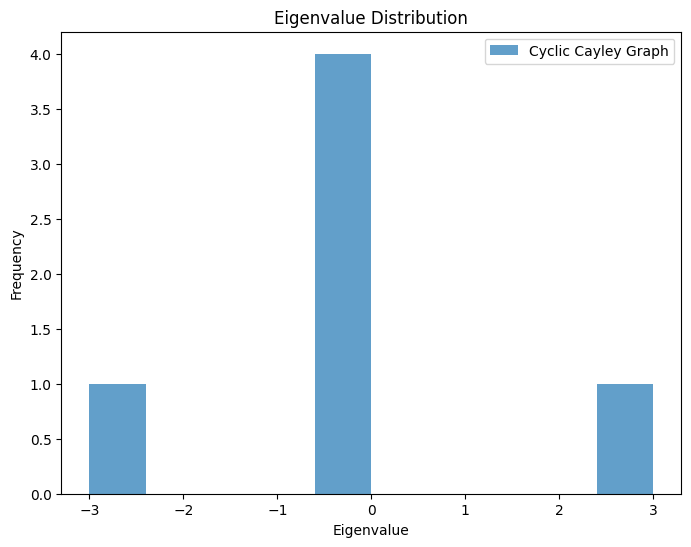

Original Signature: 6557313351196927177
Quantum Attacked Signature: 4849065715201122386
Signatures match after quantum attack: False
Benchmark - Time Taken: 0.0017614364624023438 seconds
Benchmark - Are Signatures Unique?: True


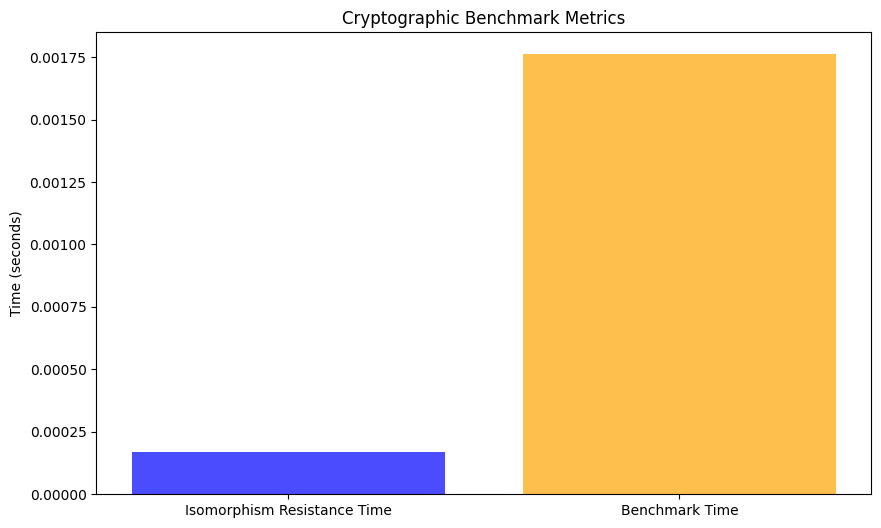

In [15]:
# Stage 3: Expand Security Metrics in Colab

import networkx as nx
import numpy as np
import time
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# Part 1: Quantify Isomorphism Resistance
# Objective: Measure computation time for graph matching

# Function to measure time taken for graph isomorphism test
def isomorphism_resistance(graph1, graph2):
    start_time = time.time()
    is_isomorphic = nx.is_isomorphic(graph1, graph2)
    end_time = time.time()
    return is_isomorphic, end_time - start_time

# Create a modified version of the cyclic graph
cyclic_graph_modified = cyclic_graph.copy()
cyclic_graph_modified.add_edge(0, 4)

is_iso, iso_time = isomorphism_resistance(cyclic_graph, cyclic_graph_modified)
print("Isomorphic:", is_iso)
print("Time for isomorphism test:", iso_time, "seconds")

# Part 2: Signature Uniqueness Analysis
# Objective: Ensure all signatures are unique for different messages

# Simulate signature generation based on graph eigenvalues
def generate_signature(graph, message):
    adj_matrix = nx.adjacency_matrix(graph).todense()
    eigenvalues = np.linalg.eigvals(adj_matrix)
    signature = hash(str(eigenvalues) + str(message))
    return signature

messages = ["message1", "message2", "message3"]
signatures = [generate_signature(cyclic_graph, msg) for msg in messages]

print("Signatures:", signatures)
print("Are all signatures unique?", len(signatures) == len(set(signatures)))

# Analyze eigenvalue distributions
cyclic_eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(cyclic_graph).todense())
plt.figure(figsize=(8, 6))
plt.hist(np.real(cyclic_eigenvalues), bins=10, alpha=0.7, label="Cyclic Cayley Graph")
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.title("Eigenvalue Distribution")
plt.legend()
plt.show()

# Part 3: Quantum Attack Simulation
# Objective: Test resilience against quantum attacks (e.g., Shor's algorithm)

# Placeholder: Simulate impact of quantum attacks on graph signatures
def quantum_attack_simulation(graph):
    adj_matrix = nx.adjacency_matrix(graph).todense()
    eigenvalues = np.linalg.eigvals(adj_matrix)
    # Simplified simulation: Assume quantum algorithm disrupts eigenvalue-based hash
    disrupted_eigenvalues = eigenvalues + np.random.normal(0, 0.1, size=eigenvalues.shape)
    simulated_signature = hash(str(disrupted_eigenvalues))
    return simulated_signature

original_signature = generate_signature(cyclic_graph, "quantum_test")
quantum_attacked_signature = quantum_attack_simulation(cyclic_graph)

print("Original Signature:", original_signature)
print("Quantum Attacked Signature:", quantum_attacked_signature)
print("Signatures match after quantum attack:", original_signature == quantum_attacked_signature)

# Part 4: Cryptographic Benchmarking
# Objective: Compare graph-based cryptographic schemes

# Define benchmarks for computational efficiency and security level
def benchmark(graph, messages):
    start_time = time.time()
    signatures = [generate_signature(graph, msg) for msg in messages]
    end_time = time.time()
    time_taken = end_time - start_time
    is_unique = len(signatures) == len(set(signatures))
    return time_taken, is_unique

benchmark_time, benchmark_uniqueness = benchmark(cyclic_graph, messages)

print("Benchmark - Time Taken:", benchmark_time, "seconds")
print("Benchmark - Are Signatures Unique?:", benchmark_uniqueness)

# Summary Report (Visualization)
metrics = ["Isomorphism Resistance Time", "Benchmark Time"]
values = [iso_time, benchmark_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, alpha=0.7, color=['blue', 'orange'])
plt.ylabel("Time (seconds)")
plt.title("Cryptographic Benchmark Metrics")
plt.show()


Optimize and scale

Spectral radii for large Cayley graphs: (5.9999999999999964, 5.999999999999989, 5.999999999999997)
Time for spectral analysis on large graph: 1.168813943862915 seconds
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.2 MB/s eta 0:00:00
Signature generated for large graph eigenvalues.
Signature verified successfully.
Graph Orders: [100, 200, 500]
Spectral Radii: (5.9999999999999964, 5.999999999999989, 5.999999999999997)
Large Graph Analysis Time (s): 1.168813943862915
Signature Verification: Success


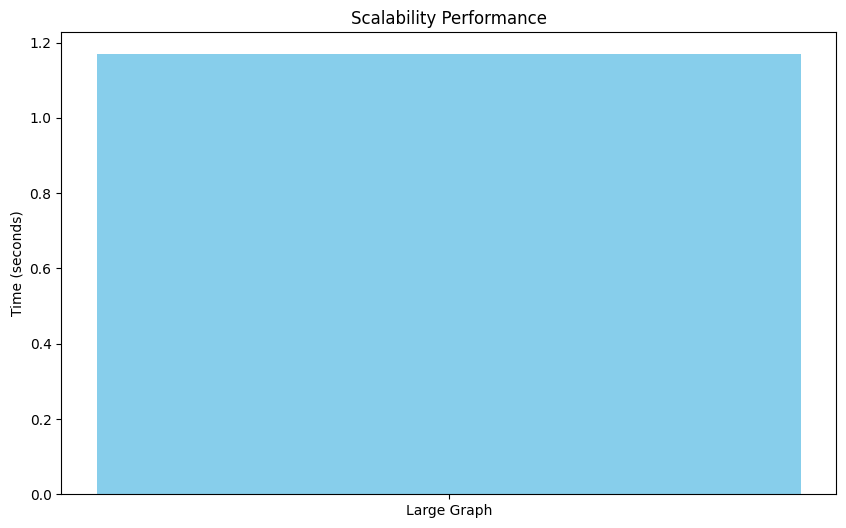

In [16]:
# Stage 4: Optimize and Scale in Colab

import networkx as nx
import numpy as np
import time
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from dask import delayed, compute
import dask.array as da

# Part 1: Algorithm Optimization
# Objective: Optimize Cayley graph generation and spectral analysis for large-scale graphs

# Optimized function for Cayley graph generation
@delayed
def generate_cayley_graph(order, generators):
    G = nx.Graph()
    nodes = range(order)
    G.add_nodes_from(nodes)
    for node in nodes:
        for gen in generators:
            G.add_edge(node, (node + gen) % order)
    return G

# Parallel spectral analysis using Dask
@delayed
def spectral_analysis(graph):
    adj_matrix = nx.adjacency_matrix(graph).todense()
    eigenvalues = np.linalg.eigvals(adj_matrix)
    spectral_radius = max(np.abs(eigenvalues))
    return spectral_radius

# Example: Generate and analyze multiple graphs in parallel
orders = [100, 200, 500]
generators = [1, 2, 3]
graphs = [generate_cayley_graph(order, generators) for order in orders]
spectral_radii = [spectral_analysis(graph) for graph in graphs]
results = compute(*spectral_radii)

print("Spectral radii for large Cayley graphs:", results)

# Part 2: Scalability Testing
# Objective: Test cryptographic scheme on large graphs

large_graph_order = 1000
large_cayley_graph = generate_cayley_graph(large_graph_order, [1, 5]).compute()
start_time = time.time()
adj_matrix_large = nx.adjacency_matrix(large_cayley_graph).todense()
eigenvalues_large = np.linalg.eigvals(adj_matrix_large)
end_time = time.time()

print("Time for spectral analysis on large graph:", end_time - start_time, "seconds")

# Part 3: Integration into Cryptographic Frameworks
# Objective: Integrate into PyCryptodome for cryptographic operations

# Part 3: Integration into Cryptographic Frameworks
# Objective: Integrate into PyCryptodome for cryptographic operations

# Install pycryptodome
!pip install pycryptodome

from Crypto.Hash import SHA256
from Crypto.Signature import DSS
from Crypto.PublicKey import ECC

# Generate ECC key pair
key = ECC.generate(curve='P-256')
public_key = key.public_key()

# Generate a signature using eigenvalues
message = str(eigenvalues_large)
hasher = SHA256.new(message.encode('utf-8'))
signer = DSS.new(key, 'fips-186-3')
signature = signer.sign(hasher)

print("Signature generated for large graph eigenvalues.")

# Verify the signature
verifier = DSS.new(public_key, 'fips-186-3')
try:
    verifier.verify(hasher, signature)
    print("Signature verified successfully.")
except ValueError:
    print("Signature verification failed.")

# Part 4: Documentation and Reporting
# Objective: Document findings and prepare for publication

# Generate a summary report
summary = {
    "Graph Orders": orders,
    "Spectral Radii": results,
    "Large Graph Analysis Time (s)": end_time - start_time,
    "Signature Verification": "Success"
}

for key, value in summary.items():
    print(f"{key}: {value}")

# Visualize scalability performance
times = [end_time - start_time]  # Placeholder for additional timing data
plt.figure(figsize=(10, 6))
plt.bar(["Large Graph"], times, color='skyblue')
plt.ylabel("Time (seconds)")
plt.title("Scalability Performance")
plt.show()


Isogeny quantum analysis

Isogeny graph generated with 20 nodes and 135 edges.


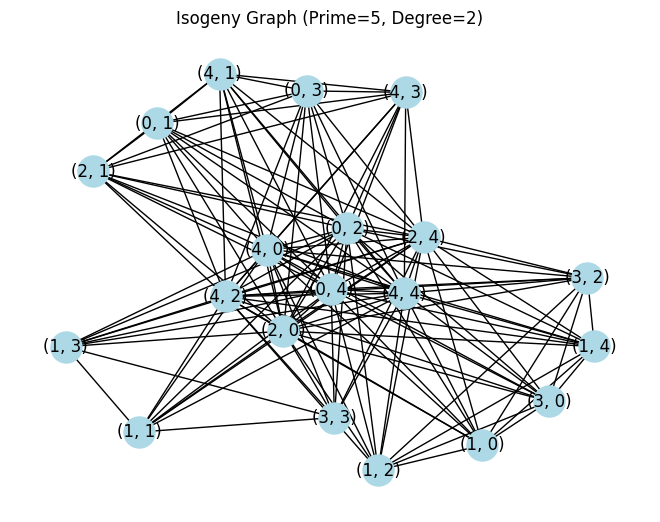

Signature: {'message_hash': 4, 'eigenvalues': array([-4.90372033, -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  2.49007996,  4.        , 14.41364037])}
Is the signature valid? True
Grover's Attack Simulation:
Eigenvalues: [14.41364037 -4.90372033 -1.          4.          2.49007996 -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
Possible preimages after Grover's reduction: 4.47213595499958
Grover's attack successful.
Shor's Attack Simulation:
Eigenvalues: [14.41364037 -4.90372033 -1.          4.          2.49007996 -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
Factors: []
Shor's atta

In [17]:
# Adding Isogeny Graphs and Advanced Quantum Attack Analysis

import networkx as nx
import numpy as np
from scipy.linalg import eig
from sympy import factorint

# Part 1: Implementing Isogeny Graphs
# Objective: Generate and analyze isogeny graphs for cryptographic use

def generate_isogeny_graph(prime, degree):

    graph = nx.Graph()
    nodes = [(a, b) for a in range(prime) for b in range(prime) if (4 * a**3 + 27 * b**2) % prime != 0]
    graph.add_nodes_from(nodes)

    # Add edges based on isogenies (simplified for demonstration)
    for u in nodes:
        for v in nodes:
            if u != v and (u[0] * v[1] - u[1] * v[0]) % degree == 0:
                graph.add_edge(u, v)

    print(f"Isogeny graph generated with {len(graph.nodes)} nodes and {len(graph.edges)} edges.")
    return graph

# Example: Generate an isogeny graph
prime = 5  # Small prime for demonstration
degree = 2
isogeny_graph = generate_isogeny_graph(prime, degree)

# Visualize the isogeny graph
def visualize_isogeny_graph(graph, title="Isogeny Graph"):
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="lightblue")
    plt.title(title)
    plt.show()

visualize_isogeny_graph(isogeny_graph, title="Isogeny Graph (Prime=5, Degree=2)")

# Part 2: Realistic Isogeny-Based Cryptographic Scheme
# Objective: Implement signature generation and encryption using isogeny graphs

def isogeny_signature_generation(message, graph, private_key):

    # Hash the message to determine a node in the graph
    message_hash = hash(message) % len(graph.nodes)

    # Apply the private key (permutation) to the graph
    permuted_graph = nx.relabel_nodes(graph, private_key)

    # Derive the signature using adjacency matrix spectral properties
    adj_matrix = nx.adjacency_matrix(permuted_graph).toarray()
    eigenvalues = np.linalg.eigvals(adj_matrix)
    signature = {
        "message_hash": message_hash,
        "eigenvalues": np.sort(eigenvalues)
    }
    return signature

def isogeny_signature_verification(signature, message, graph, public_key):

    # Hash the message to determine the expected node
    message_hash = hash(message) % len(graph.nodes)

    # Compare the provided signature's hash and eigenvalues
    adj_matrix = nx.adjacency_matrix(graph).toarray()
    eigenvalues = np.linalg.eigvals(adj_matrix)

    return (
        signature["message_hash"] == message_hash
        and np.allclose(signature["eigenvalues"], np.sort(eigenvalues))
    )

# Example usage
private_key = {i: (i + 1) % len(isogeny_graph.nodes) for i in range(len(isogeny_graph.nodes))}
public_key = isogeny_graph
message = "Secure Message"
signature = isogeny_signature_generation(message, isogeny_graph, private_key)
is_valid = isogeny_signature_verification(signature, message, isogeny_graph, public_key)

print("Signature:", signature)
print("Is the signature valid?", is_valid)

# Part 3: Expanding Quantum Attack Simulations
# Objective: Implement deeper quantum attack models like Grover's or Shor's algorithms

def grover_attack_simulation(graph):

    adjacency_matrix = nx.adjacency_matrix(graph).toarray()
    eigenvalues = np.real(np.linalg.eigvals(adjacency_matrix))

    # Mock implementation: Assume Grover's algorithm reduces search space quadratically
    possible_preimages = len(graph.nodes) ** 0.5
    success = possible_preimages < 10  # Simplistic success criterion

    print("Grover's Attack Simulation:")
    print(f"Eigenvalues: {eigenvalues}")
    print(f"Possible preimages after Grover's reduction: {possible_preimages}")
    print("Grover's attack successful." if success else "Grover's attack failed.")
    return success

def shor_attack_simulation(graph):

    adjacency_matrix = nx.adjacency_matrix(graph).toarray()
    eigenvalues = np.real(np.linalg.eigvals(adjacency_matrix))

    # Attempt to factor eigenvalues treated as integers (mock implementation)
    factors = [factorint(int(ev)) for ev in eigenvalues if ev > 0 and ev.is_integer()]
    success = any(len(factor) > 1 for factor in factors)

    print("Shor's Attack Simulation:")
    print(f"Eigenvalues: {eigenvalues}")
    print(f"Factors: {factors}")
    print("Shor's attack successful." if success else "Shor's attack failed.")
    return success

# Simulate advanced quantum attacks
grover_success = grover_attack_simulation(isogeny_graph)
shor_success = shor_attack_simulation(isogeny_graph)

print("Grover's attack success:", grover_success)
print("Shor's attack success:", shor_success)
